# Building a convolutional neural network with Tensorflow 2.0 and Keras

*** 

This notebook provides an introduction to the structure of convolutional neural networks (CNNs), and how they can be created, evaluted and used with Tensorflow and Keras. We will use the MNIST dataset to train and evaluate two CNNs: the first with 2 convolutional layers and the second with only a single convolutional layer, and find that the models have similar performance when classifying the MNIST dataset. The notebook begins with a description of the general structure of a CNN before showing their implementation using Tensorflow. 

A note about Tensorflow and Keras. Originally Keras was an API for building neural network models and required a backend to perform calculations such as Tensorflow, Theano or CNTK. However in Tensorflow 2, Keras was declared the official high-level API for Tensorflow and is inclded in the Tensorflow package as tf.keras. 

## Introduction: layers of a CNN 

### Convolution layer

The convolution uses a matrix called a **kernel**/**filter** to extract features from the image whic in this case is a 2D numpy array. The kernel typically has smaller dimensions than the image and uses a sliding dot product procedure to create a new array called a **Convolved Feature**, **Activation Map** or **Feature Map** which has the same shape as the kernel. In the following model an image will be represented by a 28x28 array and the kernel by a 3x3 array. We start by placing the kernel in the top left corner of the image (so that image(0,0) overlaps with kernel(0,0)). Then, element-wise multiplication is performed between the kernel and the subset of the image that it covers, the resulting elements are summed and this forms the (0,0) element of the Feature map. The kernel is then moved by a set amount, known as the stride, and the process is repeated until all elements of the feature map have been calculated. 

The elements of the feature map depend on the elements of the kernel, and certain kernel values will be able to pick out certain aspects of an image, such as edges, for example. Different values pick out different features, so we can use multiple kernels to generate multiple feature maps from the same image, which will map-out local features of the image. 

We choose the number of kernels and the size of the kernels, and the CNN learns the kernel values. The end feature map is determined by 3 paramters: **depth**, how many filters we use; **stride** how many elements the kernel slides when performing the sliding dot product; and **zero padding**, we may wish to surround the feature map with zeros. When creating a convolution layer, we must also specify an activation function.

**Choosing an activation function**
An activation function introduces non-linearity so that the network can be used to approximate non-linear functions, (and perfrom non-linear classification). The recitified linear unit function is a popular choice for image recognition and maps all negative arguments onto zero: f(x) = max(0,X), which will be used in the following model. The activation function will be applied after every convolution layer, however altrenatives exist such as tanh(x), the sigmoid function and others. 

### Pooling layer

Pooling is used to reduce the number of elements in the feature map to reduce computational complexity, make the network more robust to small scale changes, and introduce a degree of scale invarience to an image. It takes a subset of the feature map and returns a single value. For example, max pooling will replace the a subset of a feature map with the max value in that subset; mean pooling would replace the subset with the mean value, etc. We generally apply insert a pooling layer between convolution layers so that pooling is applied separetly to each feature map. 

### Fully connected (dense) layer

The previous steps are used to extract features that can be used to classify the the image; these are fed into the fully connected layer which is a **multilayer perceptron model** with random initial edge weights. At the hidden layers the inputs are transformed by activation functions and delivered to the output. At the output the **loss function** is evaluate using the training labels and error is backpropagated so that the network can learn the optimal weights. How the weights are optimised depends on the choice of optimisation method and on the model hyperparameters. Optimisation is based upon gradient decent, however there are multiple specific methods. The **softmax** activation function at the output layer which returns normalised class probabilities and assumes that each instance can belong to only a single class.  

***

## Implementation using Tensorflow and Keras

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

We can import common datasets from Keras.

In [8]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images,test_labels) = mnist.load_data()

We can look at the data type and the structure of the data.

In [9]:
print(train_images.shape)
print(type(train_images[0]))
print(train_images[0].shape)
print(train_labels.shape)
print(train_labels)


(60000, 28, 28)
<class 'numpy.ndarray'>
(28, 28)
(60000,)
[5 0 4 ... 5 6 8]


We can see that the training images are a set of 60,000 2D NumPy arrays, each with 28x28 elements. There are 60,000 corresponding labels which are integer-valued, these integers represent the class each image belongs to. 

In [10]:
print(test_images.shape)

(10000, 28, 28)


There are an extra 10,000 instances in the training set. We can visualise the first few images. 

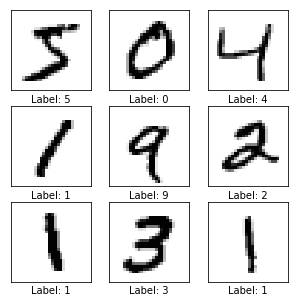

In [11]:
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.xlabel('Label:'+' '+str(train_labels[i]))
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

In [12]:
for i in range(5):
    max_value = np.amax(train_images[i])
    print(max_value)

255
255
255
255
255


The maximum value of the image arrays is 255, we will use this number to normalise the values. **Note**, these images are greyscale and have only 1 colour channel.  RGB format on the other hand can be thought of as three 2D arrays on top of each other, one for red, green and blue and would have 3 colour channels. The first convoltuion layer takes an input of 4 dimensions with shape (n_images, len(image_dimension(0)), len(image_dimension(1)), n_channels). We can write a function to make this transformation. 

In [13]:
def transform_images(image_set, NF=255, channels=1):
    
    #This function assumes all images have same shape
    return image_set.reshape(image_set.shape[0],image_set[0].shape[0],image_set[0].shape[1],channels)/NF

train_images_transformed = transform_images(train_images)
test_images_transformed = transform_images(test_images)

print(train_images_transformed.shape)
print(test_images_transformed.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


The Keras class, Sequential allows us to easy create the layers of our network by creating an instance and using the add() method to simply add layers. Keras also has classes for each type of layer, we will use Conv2D to for convolution layers and MaxPool for pooling.  

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = tf.keras.models.Sequential()

#Convulution layer: n_filters=32, kernel_shape=(3,3), activation function=relu, image shape (28,28) (depth=1)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

#Take the max value from each (2,2) subset of the feature map
model.add(layers.MaxPooling2D((2, 2)))

#Apply another 64 filters to the pooled feature map, and pool again
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#This is the multilayer perceptron part that calculates class probabilities
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                51232     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

The model summary tells us the shape of the output tensor of each layer and the number of parameters the tensor contains (the number of pixels). Next the model must be compiled, since networks are static in Tensorflow, and then trained on the training images.

In [15]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
CNN = model.fit(train_images_transformed , train_labels, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 31s 516us/sample - loss: 0.1720 - accuracy: 0.9464
Epoch 2/5
60000/60000 [==============================] - 31s 521us/sample - loss: 0.0537 - accuracy: 0.9834
Epoch 3/5
60000/60000 [==============================] - 32s 529us/sample - loss: 0.0375 - accuracy: 0.9887
Epoch 4/5
60000/60000 [==============================] - 32s 532us/sample - loss: 0.0291 - accuracy: 0.9907
Epoch 5/5
60000/60000 [==============================] - 33s 553us/sample - loss: 0.0215 - accuracy: 0.9932


The number of epochs is the amount of times the data passes through the entire network both forwards **and** backwards. After the backpropagation of error, the neuron weights are adjusted and the data is fed forward through the network again during the second epoch. Each time this happens the weights approach their optimium values, determined using gradient decent, therefore the loss should fall and the accuracy of the model should increase during training. **Note**, it is possible performance to decline after succesive epochs depending on the exact optimisation method on model hyperparameters being used.  We can get the loss and accuracy of the model after every epoch using the models history() method, and plot them against the epoch number in order to see how the model performance changes during traning. 

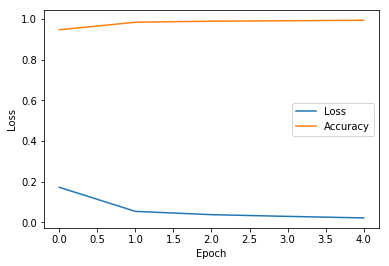

{'loss': [0.17198812485809128, 0.05370002600505638, 0.0374810935876177, 0.029104471967881546, 0.021537162734283872], 'accuracy': [0.9464167, 0.9834333, 0.98866665, 0.9906833, 0.9932333]}


In [16]:
plt.plot(CNN.history['loss'],label='Loss')
plt.plot(CNN.history['accuracy'],label='Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print(CNN.history)

Finally we can evaluate the model on the test set and make predictions.

In [17]:
test_loss, test_acc = model.evaluate(test_images_transformed,  test_labels, verbose=2)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

10000/10000 - 2s - loss: 0.0296 - accuracy: 0.9903
Test loss: 0.029592137022153474
Test accuracy: 0.9903


The test accuracey is slightly less than on the training set, which shows that the model was overfitting. This could be addressed by regularisation, however the performance is still good on the test data. The predict() method will return a set of 10 probabilities per instance, representing the probability that an instance belongs to each class.  

In [42]:
predictions = model.predict(test_images_transformed)

#Get the highest probability for each image
predicted_labels = [np.argmax(i) for i in predictions]

x0 = np.asarray(predicted_labels[0:10])
x1 = test_labels[0:10]
print(predictions[0])
print('First 10 labels:', x0)
print('First 10 predictions:', x1)

[8.95934420e-08 3.23041718e-07 1.55195465e-07 2.51202010e-07
 9.83510606e-09 5.93545568e-09 1.03443447e-12 9.99997854e-01
 1.07295804e-07 1.23974098e-06]
First 10 labels: [7 2 1 0 4 1 4 9 5 9]
First 10 predictions: [7 2 1 0 4 1 4 9 5 9]


We can visualise the output of the prediction for images. We see below that the image is classified into the correct class almost with certainty. 

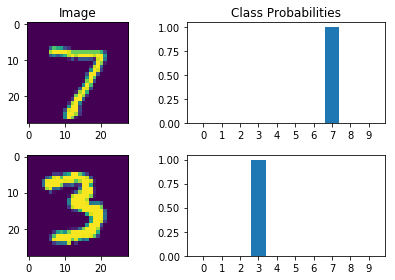

In [33]:
fig, ax  = plt.subplots(nrows=2,ncols=2)

ax[0,0].imshow(test_images[0])
ax[0,0].set_title('Image')
ax[0,1].bar(range(10), predictions[0],tick_label=range(10))
ax[0,1].set_title('Class Probabilities')
ax[1,0].imshow(test_images[500])
ax[1,1].bar(range(10), predictions[500],tick_label=range(10))
plt.tight_layout()
plt.show()

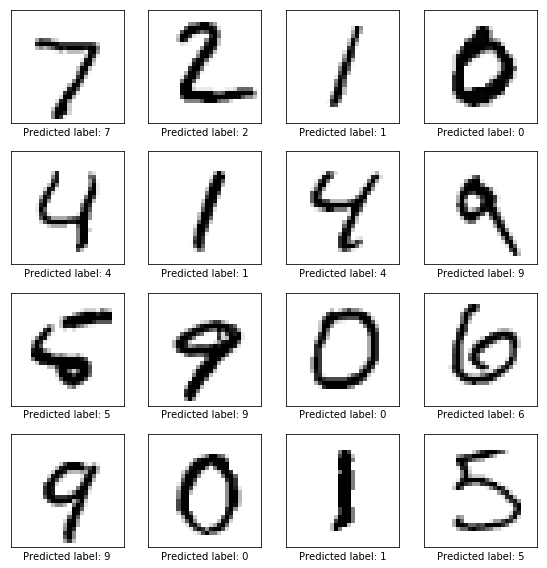

In [34]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.xlabel('Predicted label:'+' '+str(predicted_labels[i]))
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.tight_layout()
plt.show()

***

## Trying a model with less layers 

We will try a model with only one convolutional layer, applying only 32 filters, to see how the performance compares  with the original.  

In [37]:
model = tf.keras.models.Sequential()

#Convulution layer: n_filters=32, kernel_shape=(3,3), activation function=relu, image shape (28,28) (depth=1)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                173088    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_________________________________________________________________
None


This model more training parameters than the previous model, this is because during each convolution and pooling layer the data is compressed. 

In [38]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
CNN = model.fit(train_images_transformed , train_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images_transformed,  test_labels, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 285us/sample - loss: 0.2152 - accuracy: 0.9380
Epoch 2/5
60000/60000 [==============================] - 17s 280us/sample - loss: 0.0723 - accuracy: 0.9786
Epoch 3/5
60000/60000 [==============================] - 17s 283us/sample - loss: 0.0508 - accuracy: 0.9844
Epoch 4/5
60000/60000 [==============================] - 17s 283us/sample - loss: 0.0400 - accuracy: 0.9877
Epoch 5/5
60000/60000 [==============================] - 17s 283us/sample - loss: 0.0317 - accuracy: 0.9900
10000/10000 - 1s - loss: 0.0496 - accuracy: 0.9848
Test loss: 0.04956139290444553
Test accuracy: 0.9848


We can see this model has a test accuracy of 98.5%, slighly less than the previous model, with a loss of about 5% compared to 3% with the previous model. 

In [41]:
predictions = model.predict(test_images_transformed)
predicted_labels = [np.argmax(i) for i in predictions]
x0 = np.asarray(predicted_labels[0:10])
x1 = test_labels[0:10]

print('First 10 labels:', x0)
print('First 10 predictions:', x1)

First 10 labels: [7 2 1 0 4 1 4 9 5 9]
First 10 predictions: [7 2 1 0 4 1 4 9 5 9]


***

## Summary and insights

The model with 2 convolution layers performs only slightly better than the model that has a single convolution layer, suggesting the extra filters in the second layer are largely unecessary when classifying the MNIST dataset. Since each layer of of filters captures more complex patterns in the data, simple images like those in MNIST can be processed sufficiently with a small amount of filters, while more complex images would require more. 

We have covered: 

 - The basic structure common to all CNNs: convolution layers, non-linear activation functions, pooling layers and a fully connected layer. 
 - How to use Keras to build a neural network using the Sequence class. 
 - How to prepare image data so that it can be read into a CNN. 
 - How to complile, train and evalute a CNN by looking at the history of the model throught it's training. 
 - How to make predictions using a CNN. 
 
